In [60]:
import sys
sys.path.append("/dbfs/grimlock/sri/sidework/")

root_path = "/dbfs/grimlock/sri/sidework/"
root_path = "/Users/sa/CS/stanford/cs229/Project/Neural-Response-Generator-augmented-with-psychological-personalities/"

In [61]:
import pandas as pd
import autoreload
import sys
sys.path.append(root_path + "library/")

%load_ext autoreload
%autoreload 2

# Data preprocessing custom package
import text_preprocessing
from text_preprocessing import Preprocessor

pt = Preprocessor()

# essentials
import numpy as np
from tqdm.notebook import tqdm
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# load Orginal MBTI Raw data
df = pd.read_csv(root_path + "data/raw/mbti_1.csv")
data = pd.DataFrame(columns=['groupid','type', 'post'])

In [63]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [64]:
preprocess = False
seperate_same_user_post = True
groupid = 0

if preprocess:
    # Preprocess the dataset
    if seperate_same_user_post:
        for itr, row in tqdm(df.iterrows(), total=df.shape[0], mininterval=30):
            post_list = row[1].split("|||")
            for post in post_list:
                sent_list_preprocessed = ". ".join(pt.get_preprocessed_text(post, lemma=False, stop_words=False, remove_punct=True, mask_numbers=True, sentence_quality=True))
                if sent_list_preprocessed:
                    data.loc[data.shape[0]+1] = [groupid, row[0], sent_list_preprocessed]
            groupid += 1

        data.to_pickle(root_path + "data/processed/MBTI_preprocessed_v5.pkl")

    else:
        for itr, row in tqdm(df.iterrows(), total=df.shape[0], mininterval=30):
            sent_list = row[1].split("|||")
            sent_list_preprocessed = pt.get_preprocessed_text(sent_list, lemma=False, stop_words=False, remove_punct=True, mask_numbers=True, sentence_quality=True)
            if len(sent_list_preprocessed) >= 0:
                for sent in sent_list_preprocessed:
    #                 if sent!='':
    #                     if len(text.split(' '))<=5:
    #                         continue
                    data.loc[data.shape[0]+1] = [groupid, row[0], sent]
            groupid += 1

        data.to_pickle(root_path + "data/processed/MBTI_preprocessed_v4_partial.pkl")

else:
  # load the preprocessed Dataset
    data = pd.read_pickle(root_path + "data/processed/MBTI_preprocessed_v5.pkl")
    #data = pd.read_pickle(root_path + "data/processed/MBTI_preprocessed_v4_partial_samepost.pkl")

In [66]:
data.head()

,groupid,type,post
1,0,INFJ,What has been the most life-changing experienc...
2,0,INFJ,May the PerC Experience immerse you
3,0,INFJ,The last thing my INFJ friend posted on his fa...
4,0,INFJ,Hello ENFJ. Try to figure the hard times as ti...
5,0,INFJ,Prozac wellbrutin at least thirty minutes of m...


In [98]:
# strict preprocessing, remove posts with less than two sentence.

new_data = pd.DataFrame(columns=['groupid','type', 'post'])

added_post = 0
removed_post = 0
total_post = data.shape[0]
for itr, row in tqdm(data.iterrows(), total=data.shape[0], mininterval=30):
    if len(row.post.split(". ")) >=2 or len(row.post.split(" ")) >= 25:
        new_data.loc[new_data.shape[0]+1] = [row[0], row[1], row.post]
        added_post += 1
    else:
        removed_post += 1


In [100]:
print ("Percentage of posts removed: ", removed_post/total_post)

Percentage of posts removed:  0.5260302970166039


/Users/sa/.venv/dl/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


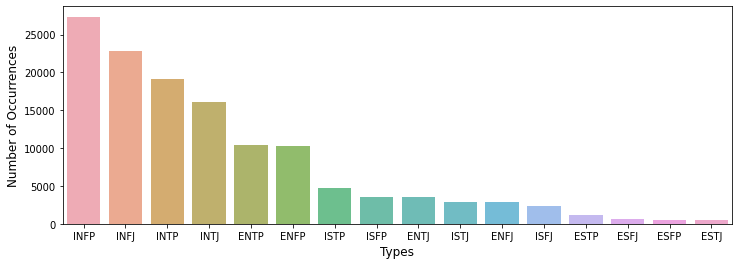

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt_srs = new_data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

/Users/sa/.venv/dl/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


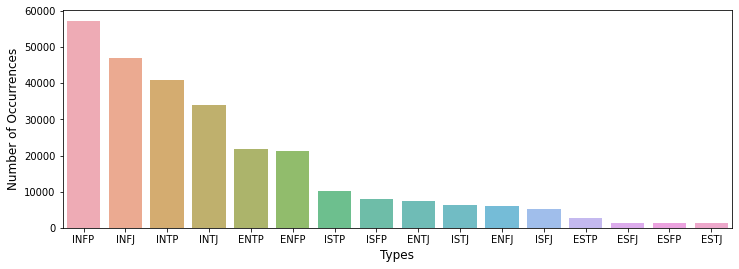

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt_srs = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [109]:
data = new_data.copy()

In [110]:
# convert personality type from string to int
labels = data['type'].unique()

label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index
    
# add label column to the data
data['label'] = data['type'].replace(label_dict)

In [111]:
label_dict

{'INFJ': 0,
 'ENTP': 1,
 'INTP': 2,
 'INTJ': 3,
 'ENTJ': 4,
 'ENFJ': 5,
 'INFP': 6,
 'ENFP': 7,
 'ISFP': 8,
 'ISTP': 9,
 'ISFJ': 10,
 'ISTJ': 11,
 'ESTP': 12,
 'ESFP': 13,
 'ESTJ': 14,
 'ESFJ': 15}

In [106]:
data.size

515880

In [112]:
# get post only if the type of personaility in top 4 by freq count
data = data[data['label'].isin([2, 3, 6, 0])].copy()
# get post only if the type of personaility in top 2 by freq count
#data = data[data['label'].isin([0,6])].copy()
# get post only if the type of personaility in top 6 by freq count
#data = data[data['label'].isin([0,2,3,6,1,7])].copy()

/Users/sa/.venv/dl/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


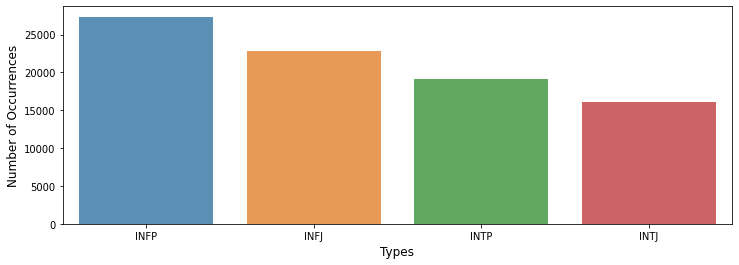

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt_srs = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data.index.values, 
                                                  data.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=data.label.values)

data['data_type'] = ['not_set']*data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

data.groupby(['type', 'label', 'data_type']).count()

groupid   post
type label data_type                
INFJ 0     train        18287  18287
           val           4572   4572
INFP 6     train        21881  21881
           val           5471   5471
INTJ 3     train        12862  12862
           val           3215   3215
INTP 2     train        15344  15344
           val           3836   3836

In [116]:
#store intermediate data results.

np.save(open(root_path + "data/intermediate/MBTI_f_v5_c4.pkl", "wb"), np.asarray([X_train, X_val, y_train, y_val]))
data.to_pickle(root_path + "data/intermediate/MBTI_df_v5_c4.pkl")

In [ ]:
# # To read the files
# X_train, X_val, y_train, y_val = np.load(open(root_path + "data/intermediate/MBTI_datasplit_v1.pkl", "rb"))
# data = pickle.load(open(root_path + "data/intermediate/MBTI_data_before_split_v1.pkl", "rb"))

# Experimenting with feature reduction

In [70]:
import sys
sys.path.append("/dbfs/grimlock/sri/sidework/")

root_path = "/dbfs/grimlock/sri/sidework/"
root_path = "/Users/sa/CS/stanford/cs229/Project/Neural-Response-Generator-augmented-with-psychological-personalities/"

In [39]:
import pandas as pd
import autoreload
import sys
sys.path.append(root_path + "library/")

%load_ext autoreload
%autoreload 2

# Data preprocessing custom package
import text_preprocessing
from text_preprocessing import Preprocessor

pt = Preprocessor()

# essentials
import numpy as np
from tqdm import tqdm
import pickle
import pickle as pkl
from scipy import sparse
from numpy import asarray
from numpy import savetxt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
import pickle

# To read the files
X_train, X_val, y_train, y_val = np.load(open(root_path + "data/intermediate/MBTI_datasplit_v4_partial_samepost.pkl", "rb"), allow_pickle=True)
data = pickle.load(open(root_path + "data/intermediate/MBTI_data_before_split_v4_partial_samepost.pkl", "rb"))

In [41]:
print ("Training set size: ", X_train.size)
print ("Validation set size: ", X_val.size)

Training set size:  6936
Validation set size:  1735


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)
vectorizer = TfidfVectorizer(ngram_range=(1,3))

corpus = list(data['post'])
vocabulary = vectorizer.fit_transform(corpus) 
X_train_vec = vectorizer.transform(list(data.loc[X_train]['post']))
X_val_vec = vectorizer.transform(list(data.loc[X_val]['post']))

In [44]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, n_iter=9, random_state=42)
vocab_red_svd = svd.fit_transform(vocabulary)

In [ ]:
# from sklearn.manifold import TSNE

# print("TSNE")
# X_tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=650).fit_transform(vocab_red_svd)

TSNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 182892 samples in 2.321s...


In [45]:
print ("Before reduction dim of training and val set: ", X_train_vec.shape[1],"  ", X_val_vec.shape[1])
X_train_vec_red_svd = svd.transform(X_train_vec)
X_val_vec_red_svd = svd.transform(X_val_vec)
print ("After reduction dim of training and val set: ", X_train_vec_red_svd.shape[1]," ", X_val_vec_red_svd.shape[1])

Before reduction dim of training and val set:  6613227    6613227
After reduction dim of training and val set:  100   100


In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_vec_red_svd = scaler.fit_transform(X_train_vec_red_svd)
X_val_vec_red_svd = scaler.transform(X_val_vec_red_svd)

In [117]:
X_train, X_val, y_train, y_val = np.load(open(root_path + "data/intermediate/MBTI_datasplit_v5_c4_features.pkl", "rb"), allow_pickle=True)

In [119]:
def model_comparison(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy', n_jobs=-1, verbose=True))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted', n_jobs=-1, verbose=True))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted', n_jobs=-1, verbose=True))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted', n_jobs=-1, verbose=True))
    y_pred = model.predict(X_test)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity'  : [specificity]
                            })
    print ("done with: ", name)
    return df_model


In [11]:
from sklearn.metrics import r2_score

def model_comparison(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(X_train, y_train)
#     accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
#     precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
#     recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
#     f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    r2     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='r2'))
    y_pred = model.predict(X_test)
    r2_test = r2_score(y_test, y_pred)
    print (r2, r2_test)
    return model
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity'  : [specificity]
                            })
    print ("done with: ", name)
    return df_model


In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingRegressor


#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, multilabel_confusion_matrix

models = {'xgboost': GradientBoostingClassifier(verbose=True, learning_rate=0.1, max_depth=3, subsample=1, n_estimators=1000, warm_start=True)
         }
#models = {'xgboostRegression': GradientBoostingRegressor(verbose=True, learning_rate=0.7)
#         }
# models = {'gnb': GaussianNB(),
#            'mnb': MultinomialNB(),
#            'logit': LogisticRegression(),
#            'knn': KNeighborsClassifier(),
#            'decisiontree': DecisionTreeClassifier(),
#            'randomforest': RandomForestClassifier(),
#            'xgboost': GradientBoostingClassifier(),
#            'MLPC': MLPClassifier()
#           }
models = {'logit': LogisticRegression(max_iter=1000)}

In [122]:

models_svd_class4_svd= pd.concat([model_comparison(model, X_train, X_val, y_train, y_val, name) for (name, model) in models.items()])
models_svd_class4_svd

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


done with:  logit


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


,model,accuracy,precision,recall,f1score,specificity
0,logit,0.359159,0.359251,0.35909,0.354007,0.196868


In [59]:

models_svd_class4_svd= pd.concat([model_comparison(model, X_train_vec_red_svd, X_val_vec_red_svd, y_train, y_val, name) for (name, model) in models.items()])
models_svd_class4_svd

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


done with:  gnb


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


done with:  mnb


/Users/sa/.venv/dl/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend L

done with:  logit


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


done with:  knn


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


done with:  decisiontree


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


done with:  randomforest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min finished


done with:  xgboost


/Users/sa/.venv/dl/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


done with:  MLPC


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.514994,0.558576,0.520473,0.516309,0.966787
0,mnb,0.211217,0.044613,0.211217,0.073666,0.937500
0,logit,0.613754,0.625275,0.614619,0.597842,0.973258
0,knn,0.321223,0.356812,0.324394,0.310794,0.951412
0,decisiontree,0.295415,0.309502,0.302624,0.297960,0.951162
0,randomforest,0.501730,0.543006,0.500865,0.454926,0.963532
0,xgboost,0.547290,0.543424,0.564591,0.536506,0.968014
0,MLPC,0.641292,0.641286,0.637976,0.629453,0.975400


In [105]:
y_train.shape

(4556,)

In [109]:
# Simple model training and evaluation
#learning_rate = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]
#for lr in learning_rate:
# n_iter_no_change=1
gb = GradientBoostingClassifier(verbose=True, learning_rate=0.1, max_depth=3, subsample=0.7, n_estimators=1000, warm_start=True)
gb.fit(X_train_vec_red_svd, y_train)
#mlp = MLPClassifier(verbose=True, max_iter=2000)
#mlp.fit(X_train_vec_red_svd, y_train)
learning_rate = 0.1
print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_vec_red_svd, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(X_val_vec_red_svd, y_val)))
print()

# 92 - 70 {early stopping with 3}
# 96 - 71 {n_estimator as 200}
# 99 - 72 {n_estimator as 300}
# 100 - 72 {n_estimator as 400}

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3135           0.0495            9.50m
         2           1.2649           0.0385            9.19m
         3           1.2271           0.0326            9.16m
         4           1.1899           0.0276            9.13m
         5           1.1642           0.0230            9.09m
         6           1.1317           0.0214            9.06m
         7           1.1118           0.0218            9.05m
         8           1.0876           0.0183            9.03m
         9           1.0597           0.0153            9.02m
        10           1.0472           0.0136            9.02m
        20           0.8862           0.0065            8.88m
        30           0.7935           0.0026            8.77m
        40           0.7180           0.0016            8.57m
        50           0.6538           0.0004            8.43m
        60           0.6011           0.0013            8.32m
       

In [ ]:
figure = plt.figure(figsize=(27, 9))
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
if ds_cnt == 0:
    ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# Extra

In [1]:
import sys
sys.path.append("/dbfs/grimlock/sri/sidework/")

root_path = "/dbfs/grimlock/sri/sidework/"
root_path = "/Users/sa/CS/stanford/cs229/Project/Neural-Response-Generator-augmented-with-psychological-personalities/"

In [2]:
import pandas as pd
import autoreload
import sys
sys.path.append(root_path + "library/")

%load_ext autoreload
%autoreload 2

# Data preprocessing custom package
import text_preprocessing
from text_preprocessing import Preprocessor

pt = Preprocessor()

# essentials
import numpy as np
from tqdm.notebook import tqdm
import pickle

[nltk_data] Downloading package wordnet to /tmp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /tmp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /tmp/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /tmp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#data = pd.read_pickle(root_path + "data/processed/MBTI_preprocessed_v4_partial.pkl")
data = pd.read_pickle(root_path + "data/processed/MBTI_preprocessed_v4_partial.pkl")

# convert personality type from string to int
labels = data['type'].unique()

label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index
    
# add label column to the data
data['label'] = data['type'].replace(label_dict)

In [4]:
import nltk

In [5]:
from textblob import TextBlob
from textblob.translate import NotTranslated
import random
sr = random.SystemRandom()

language = ["es", "de", "fr", "ar", "te", "hi", "ja", "fa", "sq", "bg", "nl", "gu", "ig", "kk", "mt", "ps"]

def data_augmentation(message, language, aug_range=1):
    augmented_messages = []
    if hasattr(message, "decode"):
        message = message.decode("utf-8")

    for j in range(0,aug_range) :
        new_message = ""
        text = TextBlob(message)
        try:
            text = text.translate(to=sr.choice(language))   ## Converting to random langauge for meaningful variation
            text = text.translate(to="en")
        except NotTranslated:
            pass
        augmented_messages.append(str(text))

    return augmented_messages

In [6]:
df = data[data['label'].isin([7,9,8,4,11,5,10,12,13,15,14])].copy()
#df = data.copy()

/Users/sa/.venv/dl/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


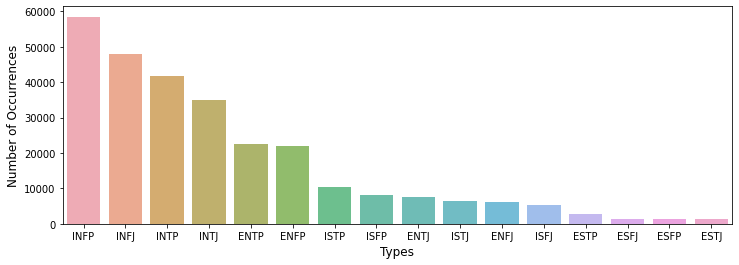

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt_srs = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

/Users/sa/.venv/dl/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


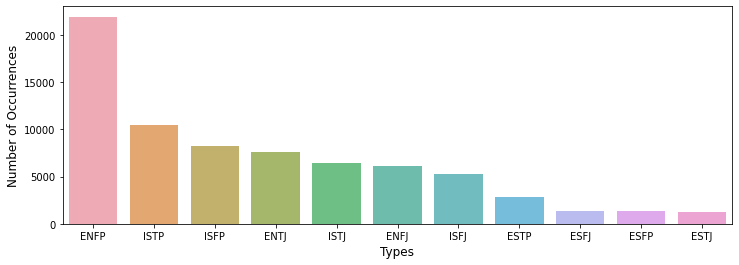

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt_srs = df['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [9]:
intent_count = df.label.value_counts().to_dict()

In [10]:
import operator
max_intent_count = max(intent_count.items(), key=operator.itemgetter(1))[1]
#max_intent_count = round(np.mean(list(intent_count.values())))

In [11]:
data.head()

,groupid,type,post,label
1,0,INFJ,What has been the most life-changing experienc...,0
2,1,INFJ,May the PerC Experience immerse you,0
3,2,INFJ,Hello ENFJ Sorry to hear of your distress it i...,0
4,3,INFJ,Prozac wellbrutin at least thirty minutes of m...,0
5,4,INFJ,Basically come up with three items you have de...,0


In [107]:
from tqdm.notebook import tqdm
for itr, msg in tqdm(df[df["label"] == 4][:5].iterrows(), total=df.shape[0], mininterval=30):
    print (msg.post)
    
#tqdm(df.iterrows(), total=df.shape[0], mininterval=30)

that is another silly misconception That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to Nobody wants to be approached with BS
But guys he REALLY wants to go on a super-duper-long-ass vacation C'mon guys His boss just does not listen or get it He even approached him logically and everything
Never mind Just go on permanent vacation
Two months I would not be crazy about the idea If you are really his best employee then that is what may be cooking him Who wants their most reliable asset gone for that long ENTJ employer
I probably would have lost it too His stonewalling was insignificant He was being an idiot over semantics that did not have any impact on anything it is one thing to stone wall on critical shit but



In [12]:
from tqdm.notebook import tqdm

newdf = pd.DataFrame()

for intent, count in intent_count.items():
    print ("updating intent :", intent)
    count_diff = max_intent_count - count
    for itr, message in tqdm(df[df["label"] == intent][:count_diff].iterrows(), total=count_diff):
        new_messages = data_augmentation(message.post, language)
        df.loc[df.shape[0]+1] = [message.groupid, message.type, new_messages, message.label]

updating intent : 7



updating intent : 9


KeyboardInterrupt: 

In [ ]:
## Loop to interate all messages
import numpy as np
import math
import tqdm
newdf = pd.DataFrame()
for intent, count in intent_count.items():
    print ("intent: ", intent, " out of ", len(intent_count))
    count_diff = max_intent_count - count    ## Difference to fill
    multiplication_count = math.ceil((count_diff)/count)  ## Multiplying a minority classes for multiplication_count times
    if (multiplication_count):
        old_message_df = pd.DataFrame()
        new_message_df = pd.DataFrame()
        for message in tqdm.tqdm(df[df["label"] == intent]["post"]) :
            ## Extracting existing minority class batch
            dummy1 = pd.DataFrame([message], columns=['post'])
            dummy1["label"] = intent
            old_message_df = old_message_df.append(dummy1)
            
            ## Creating new augmented batch from existing minority class
            new_messages = data_augmentation(message, language, multiplication_count)
            dummy2 = pd.DataFrame(new_messages, columns=['post'])
            dummy2["label"] = intent
            new_message_df = new_message_df.append(dummy2)
        
        ## Select random data points from augmented data
        new_message_df=new_message_df.take(np.random.permutation(len(new_message_df))[:count_diff])
        
        ## Merge existing and augmented data points
        newdf = newdf.append([old_message_df,new_message_df])
    else :
        newdf = newdf.append(df[df["label"] == intent])

In [32]:
data_augmentation("Hello ENFJ Sorry to hear of your distress it is only natural for a relationship to not be perfection all the time in every moment of existence Try to figure the hard times as times of growth as. Prozac wellbrutin at least thirty minutes of moving your legs and I do not mean moving them while sitting in your same desk chair weed in moderation maybe try edibles as a healthier alternative.",language)

['Hello ENFJ Feel free to feel your pain, it is a reality for a relationship not to be full-time at all times of existence Try to describe a difficult time as an adult as. Prozac examines at least 30 minutes of moving your legs, I don’t mean moving them while sitting in your reclining chair and maybe trying to eat like a healthy alternative.']